In [83]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle

## Loading the Data ##
The dataset that we'll be working with is located in *spectrograms_gtzan*. This dataset will be easier to work with than the FMA dataset,
as it is smaller and already contains the genre class in the name of the image file. This will make matching an image to a genre easy to do.

In [3]:
print(os.getcwd())

D:\Analytics


In [16]:
data_dir = r'spectrograms_gtzan'
files = os.listdir(data_dir)
genres = [genre.split('.')[0] for genre in files]
s = {'files': files, 'genres': genres}
data = pd.DataFrame(s)

In [17]:
data

,files,genres
0,blues.00000.png,blues
1,blues.00001.png,blues
2,blues.00002.png,blues
3,blues.00003.png,blues
4,blues.00004.png,blues
...,...,...
995,rock.00095.png,rock
996,rock.00096.png,rock
997,rock.00097.png,rock
998,rock.00098.png,rock


## Partitioning Data into Train and Test sets ##
Now that we have the class names for each image, we need to partition the data into train and test sets. We'll follow the traditional 80-20 split between train and test. Let's think a bit about what that will entail. The dataset contains equal amounts of music pieces for each genre, and there are 10 genres. This means that for the 80-20 split, each genre should contain exactly 80 files in the training set, and 20 files in the test set.

In [55]:
data_array = np.array([files,genres]).transpose()
print(np.shape(data_array))
print(data_array)
np.random.shuffle(data_array)
print(np.shape(data_array))
print(data_array)
#shuffled_dict = {'files': shuffled[0][:], 'genres': shuffled[1][:]}
#shuffled_data = pd.DataFrame(s)

(1000, 2)
[['blues.00000.png' 'blues']
 ['blues.00001.png' 'blues']
 ['blues.00002.png' 'blues']
 ...
 ['rock.00097.png' 'rock']
 ['rock.00098.png' 'rock']
 ['rock.00099.png' 'rock']]
(1000, 2)
[['blues.00055.png' 'blues']
 ['rock.00075.png' 'rock']
 ['rock.00059.png' 'rock']
 ...
 ['classical.00015.png' 'classical']
 ['country.00044.png' 'country']
 ['jazz.00069.png' 'jazz']]


In [58]:
shuffled_data = pd.DataFrame(data_array, columns=['file', 'genre'])

In [59]:
shuffled_data

,file,genre
0,blues.00055.png,blues
1,rock.00075.png,rock
2,rock.00059.png,rock
3,jazz.00036.png,jazz
4,jazz.00044.png,jazz
...,...,...
995,metal.00050.png,metal
996,reggae.00008.png,reggae
997,classical.00015.png,classical
998,country.00044.png,country


In [167]:
row, col = np.shape(data_array)
train = data_array[:950][:]
test = data_array[950:][:]
train_frame = pd.DataFrame(train, columns=['file', 'genre'])
test_frame = pd.DataFrame(test, columns=['file', 'genre'])

In [168]:
train_frame

,file,genre
0,blues.00055.png,blues
1,rock.00075.png,rock
2,rock.00059.png,rock
3,jazz.00036.png,jazz
4,jazz.00044.png,jazz
...,...,...
945,pop.00044.png,pop
946,metal.00051.png,metal
947,country.00083.png,country
948,hiphop.00029.png,hiphop


In [169]:
test_frame

,file,genre
0,classical.00061.png,classical
1,jazz.00028.png,jazz
2,metal.00055.png,metal
3,disco.00015.png,disco
4,hiphop.00033.png,hiphop
5,metal.00073.png,metal
6,hiphop.00059.png,hiphop
7,metal.00094.png,metal
8,hiphop.00046.png,hiphop
9,disco.00048.png,disco


## Loading Images and Pickling Data ##
At this point we have everything we need to begin loading image data. We'll also pickle the results to make it easy to pick up where we left off
in case we need to leave here.

blues.00055.png


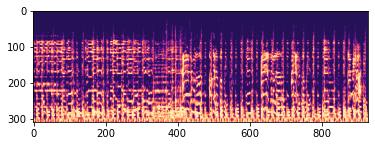

In [170]:
# perform some EDA on the spectrogram image data
filename = train[0][0]
print(filename)
image_array = cv2.imread(os.path.join(data_dir,filename), cv2.IMREAD_GRAYSCALE)  # greyscale shouldn't matter versus heatmap
plt.imshow(image_array, cmap='magma')
plt.show()

In [171]:
print(image_array.shape)

(308, 930)


In [77]:
# check to see if all images are of the same size
shape = (308, 930)
for file in train[:][0]:
    image_array = cv2.imread(os.path.join(data_dir, filename), cv2.IMREAD_GRAYSCALE)
    if image_array.shape != shape:
        print('diff on: ', file)
        break

In [172]:
Xs = []
Ys = [] # classifier
for piece in train:
    image_array = cv2.imread(os.path.join(data_dir, piece[0]), cv2.IMREAD_GRAYSCALE)
    image_array = cv2.resize(image_array, (100, 300))
    Xs.append(image_array)
    Ys.append(piece[1])

In [173]:
Xs = np.array(Xs)
Ys = np.array(Ys)

In [175]:
os.mkdir('GTZAN_PICKLE')
with open('GTZAN_PICKLE\\X.pickle','wb') as pickle_out:
    pickle.dump(Xs, pickle_out)
with open('GTZAN_PICKLE\\Y.pickle', 'wb') as pickle_out:
    pickle.dump(Ys, pickle_out)

In [85]:
## if picking up when left off, uncomment the following to load ##
"""
with open('GTZAN_PICKLE\\X.pickle,'rb') as pickle_in:
    Xs = pickle.load(pickle_in)
with open('GTZAN_PICKLE\\Y.pickle,'rb) as pickle_in:
    Ys = pickle.load(pickle_in)
"""

"\nwith open('GTZAN_PICKLE\\X.pickle,'rb') as pickle_in:\n    Xs = pickle.load(pickle_in)\nwith open('GTZAN_PICKLE\\Y.pickle,'rb) as pickle_in:\n    Ys = pickle.load(pickle_in)\n"

## Training the CNN ##
At this point we have everything we need to begin training the convolutional neural net. We'll be using Tensorflow for the remainder of the model building.

In [216]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras import regularizers

In [260]:
cnn_model = Sequential()
cnn_model.add(Conv2D(input_shape = (100, 300, 1), filters = 2, kernel_size=(5,5), padding='Same', kernel_regularizer=regularizers.l2(0.001),
                    activation='relu', strides=3))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(filters = 4, kernel_size=(5,5), padding='Same', activation='relu', strides=3))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(10, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [261]:
unique_genres = []
for genre in data['genres']:
    if genre not in unique_genres:
        unique_genres.append(genre)
print(unique_genres)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [262]:
# Need to set Ys to categorical
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
encoder = preprocessing.LabelEncoder()
encoder.fit(Ys)
encoded_Y = encoder.transform(Ys)
Ys_onehot = to_categorical(encoded_Y)

In [263]:
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

In [264]:
fit = cnn_model.fit(Xs.reshape(-1,100,300,1), Ys_onehot, validation_split=0.1, batch_size=50, epochs=100, verbose=1)

Train on 855 samples, validate on 95 samples
Epoch 1/100
855/855 [==============================] - 1s 930us/sample - loss: 2.6734 - accuracy: 0.0982 - val_loss: 2.6501 - val_accuracy: 0.1474
Epoch 2/100
855/855 [==============================] - 0s 129us/sample - loss: 2.4272 - accuracy: 0.1263 - val_loss: 2.4068 - val_accuracy: 0.1263
Epoch 3/100
855/855 [==============================] - 0s 117us/sample - loss: 2.2985 - accuracy: 0.1520 - val_loss: 2.2844 - val_accuracy: 0.1474
Epoch 4/100
855/855 [==============================] - 0s 117us/sample - loss: 2.2765 - accuracy: 0.1380 - val_loss: 2.3294 - val_accuracy: 0.1474
Epoch 5/100
855/855 [==============================] - 0s 117us/sample - loss: 2.2593 - accuracy: 0.1532 - val_loss: 2.3130 - val_accuracy: 0.1263
Epoch 6/100
855/855 [==============================] - 0s 123us/sample - loss: 2.2391 - accuracy: 0.1801 - val_loss: 2.2613 - val_accuracy: 0.1263
Epoch 7/100
855/855 [==============================] - 0s 117us/sample - 

In [194]:
def mkTrainingPlots(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

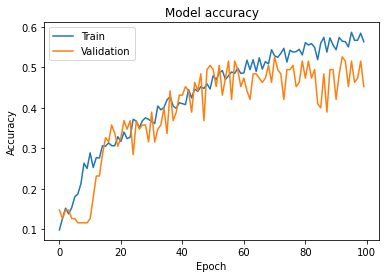

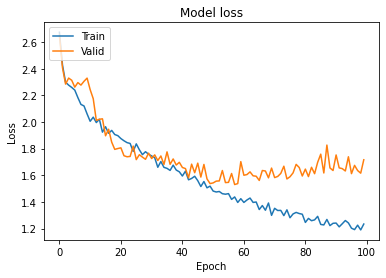

In [265]:
mkTrainingPlots(fit)

In [253]:
cnn_model.save('gtzan_cnn.model')

INFO:tensorflow:Assets written to: gtzan_cnn.model\assets
